Project Churn:
    - Creating a Binary Classifier to predict Instances that will Churn('LOST')
    - Training and Testing Using Instances, Contracts on all columns as of 04/05/17 
                                          and quarters: '2016 Q 4', '2017 Q 1', '2017 Q 2', '2017 Q 3' 

### Load Libraries

In [1]:
import cx_Oracle
import itertools
import numpy as np
import pandas as pd
import time

from collections import defaultdict
from datetime import date

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

### Load Useful Functions

In [2]:
def timer(start, end):
    time_taken = end - start 
    hours, rest = divmod(time_taken, 3600)
    minutes, seconds = divmod(rest, 60)
    return "Process took: {} hours, {} minutes, {} seconds".format(hours, minutes, seconds)

### Connect to Oracle

In [3]:
def connect_to_oracle(flag='DVTAS3'):
    if flag == 'DVTA13':
        conn = cx_Oracle.connect('VTAS_SLSFIN/a8tvzGVS@vmsodvtas011.ORACLEOUTSOURCING.COM:5010/DVTA13')
    else:
        conn = cx_Oracle.connect('DVTAS3_DW/KCu_A6BV@vmsodvtas001.ORACLEOUTSOURCING.COM:5010/DVTAS3')
    return conn

conn = connect_to_oracle('DVTA13')
curs = conn.cursor()
curs.arraysize = 1000

### Get data

In [4]:
# Create starter df with column names
col_names =['INSTANCE_ID', 'CONTRACT_ID', 'OPTY_STATUS', 'ITEM_QUANTITY', 'PRICE_NEGOTIATED', 'ERP_ID', 'PARTY_SITE_NUMBER',
              'X_CDH_ID', 'PARTY_SITE_ID', 'PARTY_SITE_ID_VALIDATION', 'INSTALL_SITE_ID', 'SFDC_ID', 'SIC_CODE',
              'PRIMARYSIC', 'ACCOUNT_NAME', 'SALES_CHANNEL_CODE', 'INSTANCE_COUNT', 'START_DATE', 'EXPIRATION_DATE',
              'CONTRACT_LENGTH', 'INVENTORY_ITEM_ID', 'INVENTORY_ITEM_ID_VALIDATION', 'PRODUCT', 'BUYING_PROGRAM', 'SUB_REGION',
              'KEY_CUST_FLAG', 'INSTANCE_AGE', 'INDUSTRY', 'LOST_CONTRACTS', 'TOTAL_INSTANCES_OWNED','CONTRACT_LINE_END_DATE',
              'CONTRACT_LINE_STATUS_CODE', 'NXT_CONTRACT_LN_END_DATE', 'NXT_CONTRACT_LN_STATUS_CODE', 'PAST_CASE_COUNT',
              'HIGH_SEVERITY_COUNT', 'PAST_ESCALATION_COUNT', 'OPTY_AMT']
df = pd.DataFrame(np.zeros((1, 38)), columns=col_names)

# create a loop to concatenate the other quarters
for qtr in ['2016 Q 4', '2017 Q 1', '2017 Q 2', '2017 Q 3']:
    print("Processing... ", qtr)
    querystring = "SELECT * FROM CHURN_V1 WHERE EXPIRATION_DATE = '" + qtr + "'"
    curs.execute(querystring)
    start = time.time()
    res = curs.fetchall()
    end = time.time()
    print(timer(start, end))
    df_temp = pd.DataFrame(res, columns=col_names)
    print("Number of records for " + qtr + " :", df_temp.shape[0])
    df = pd.concat([df, df_temp])
    
# Run only once
df.drop(df.iloc[0, :], inplace=True)

Processing...  2016 Q 4
Process took: 0.0 hours, 0.0 minutes, 37.049999952316284 seconds
Number of records for 2016 Q 4 : 203998
Processing...  2017 Q 1
Process took: 0.0 hours, 0.0 minutes, 27.407999992370605 seconds
Number of records for 2017 Q 1 : 153434
Processing...  2017 Q 2
Process took: 0.0 hours, 0.0 minutes, 22.232399940490723 seconds
Number of records for 2017 Q 2 : 143676
Processing...  2017 Q 3
Process took: 0.0 hours, 0.0 minutes, 16.602400064468384 seconds
Number of records for 2017 Q 3 : 100524


In [5]:
print("Number of records total: ", df.shape[0])
# Number of InstanceID's by Opty_Status
df.groupby('OPTY_STATUS')['INSTANCE_ID'].count()

Number of records total:  601628


OPTY_STATUS
LOST       290919
RENEWED    310709
Name: INSTANCE_ID, dtype: int64

In [8]:
df_build = df.copy()

In [ ]:
'INSTANCE_ID' -- identifier
'CONTRACT_ID' -- identifier
'ERP_ID', -- identifier
'PARTY_SITE_NUMBER', -- identifier
'X_CDH_ID', -- identifier
'PARTY_SITE_ID', -- identifier
'PARTY_SITE_ID_VALIDATION', -- identifier
'INSTALL_SITE_ID', -- identifier
'SFDC_ID', -- identifier
'PRIMARYSIC', -- identifier
'INVENTORY_ITEM_ID', -- identifier
'INVENTORY_ITEM_ID_VALIDATION', -- identifier


'ITEM_QUANTITY' -- numeric NO MODIFICATION NEEDED
'PRICE_NEGOTIATED', -- numeric NO MODIFICATION NEEDED
'INSTANCE_COUNT', -- numeric NO MODIFICATION NEEDED
'INSTANCE_AGE', -- numeric ROW REMOVE
'LOST_CONTRACTS', -- numeric ROW REMOVE
'PAST_CASE_COUNT', -- numeric FILL IN 0
'HIGH_SEVERITY_COUNT', -- numeric FILL IN 0
'PAST_ESCALATION_COUNT', -- numeric FILL IN 0
'OPTY_AMT', -- numeric FILL IN 0
'CONTRACT_LENGTH', -- numeric ROW REMOVE
'TOTAL_INSTANCES_OWNED', -- numeric ROW REMOVE


'SIC_CODE', -- categorical
'ACCOUNT_NAME', -- categorical
'SALES_CHANNEL_CODE', -- categorical
'START_DATE', -- categorical? remove year, keep only quarter ('2017 Q 1' --> 'Q 1')
'EXPIRATION_DATE', -- categorical? remove year, keep only quarter ('2017 Q 1' --> 'Q 1')
'PRODUCT', -- categorical
'BUYING_PROGRAM', -- categorical
'SUB_REGION', -- categorical
'INDUSTRY', -- categorical DROP (TOO MANY MISSING VALUES)
'CONTRACT_LINE_STATUS_CODE', -- categorical DROP NOT NEEDED
'NXT_CONTRACT_LN_STATUS_CODE', -- categorical DROP NOT NEEDED


'KEY_CUST_FLAG', -- drop?
'CONTRACT_LINE_END_DATE', -- drop?
'NXT_CONTRACT_LN_END_DATE', -- drop? 

'OPTY_STATUS' -- label? 

In [6]:
df.isnull().sum()/df.shape[0]

INSTANCE_ID                     0.000000
CONTRACT_ID                     0.000000
OPTY_STATUS                     0.000000
ITEM_QUANTITY                   0.000000
PRICE_NEGOTIATED                0.000000
ERP_ID                          0.011490
PARTY_SITE_NUMBER               0.002392
X_CDH_ID                        0.283539
PARTY_SITE_ID                   0.002392
PARTY_SITE_ID_VALIDATION        0.000000
INSTALL_SITE_ID                 0.000000
SFDC_ID                         0.283539
SIC_CODE                        0.283539
PRIMARYSIC                      0.438793
ACCOUNT_NAME                    0.012044
SALES_CHANNEL_CODE              0.012086
INSTANCE_COUNT                  0.000000
START_DATE                      0.000156
EXPIRATION_DATE                 0.000000
CONTRACT_LENGTH                 0.000156
INVENTORY_ITEM_ID               0.000000
INVENTORY_ITEM_ID_VALIDATION    0.000000
PRODUCT                         0.000000
BUYING_PROGRAM                  0.000000
SUB_REGION      

In [17]:
df[['INSTANCE_ID', 'CONTRACT_ID','ACCOUNT_NAME','INDUSTRY']][df.INDUSTRY.isnull()].shape[0]

263990

In [18]:
df.shape[0]

601628

In [19]:
263990/601628

0.43879274235906573

### Drop Columns with too many missing values or not needed

In [20]:
# Too many missing values to fill
df.drop(['KEY_CUST_FLAG', 'INDUSTRY'], axis=1, inplace=True)

# Drop Indentifier Columns
df.drop(['ERP_ID', 'PARTY_SITE_NUMBER', 'X_CDH_ID', 'PARTY_SITE_ID','PARTY_SITE_ID_VALIDATION', 
         'INSTALL_SITE_ID', 'SFDC_ID', 'PRIMARYSIC', 'INVENTORY_ITEM_ID', 'INVENTORY_ITEM_ID_VALIDATION'], 
        axis=1, inplace=True)

# Drop Unnecessary Columns: These are dropped for now since the expiration date has passed.
df.drop(['CONTRACT_LINE_END_DATE','CONTRACT_LINE_STATUS_CODE', 'NXT_CONTRACT_LN_END_DATE', 'NXT_CONTRACT_LN_STATUS_CODE'], 
        axis=1, inplace=True)

### Fill in Missing Values

In [21]:
# Fill numerical columns nan's with zeros
df.PAST_CASE_COUNT.fillna(value=0, inplace=True)  # 80% missing values
df.PAST_ESCALATION_COUNT.fillna(value=0, inplace=True)  # 80% missing values
df.HIGH_SEVERITY_COUNT.fillna(value=0, inplace=True)  # 80% missing values
df.OPTY_AMT.fillna(value=0, inplace=True)  # 41% missing values

# Fill in with 'OTHER'
df.SUB_REGION.fillna('OTHER', inplace=True)
df.BUYING_PROGRAM.fillna('OTHER', inplace=True)

# Fill in with 'NOT AVAILABLE'
df.ACCOUNT_NAME.fillna('NOT AVAILABLE', inplace=True)
df.SIC_CODE.fillna('NOT AVAILABLE', inplace=True)

# Remove rows with * in ACCOUNT_NAME
df = df[~df.ACCOUNT_NAME.str.startswith("*")]

### Drop all other Rows that cannot be filled, are still missing values

In [22]:
# Drop all rows with Missing Values
print("Number of rows before dropping rows of missing values: ", df.shape[0])
df_no_missing = df.dropna()
print("Number of rows AFTER dropping rows of missing values: ", df_no_missing.shape[0])

Number of rows before dropping rows of missing values:  600060
Number of rows AFTER dropping rows of missing values:  588367


### Creating Dictionary for Label Encoder()

In [23]:
def remove_year(row):
    return row[5:]

df_no_missing['START_QTR'] = df_no_missing.START_DATE.apply(remove_year)
df_no_missing['EXPIRATION_QTR'] = df_no_missing.EXPIRATION_DATE.apply(remove_year)

C:\Users\katherine.aquino\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\katherine.aquino\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
unique_categories = {}
categorical_columns = ['SIC_CODE','ACCOUNT_NAME', 'SALES_CHANNEL_CODE','PRODUCT', 'BUYING_PROGRAM', 'SUB_REGION']
for category in categorical_columns:
    querystring = "SELECT DISTINCT(" + category + ") FROM CHURN_V1 ORDER BY "+ category
    curs.execute(querystring)
    start = time.time()
    res = curs.fetchall()
    end = time.time()
    print(timer(start, end))
    df_temp = pd.DataFrame(res)
    print("Number of unique {0} {1}: ".format(category, df_temp.shape[0]))
    unique_categories[category] = df_temp.loc[:, 0].values

Process took: 0.0 hours, 0.0 minutes, 0.18719983100891113 seconds
Number of unique SIC_CODE 1129: 
Process took: 0.0 hours, 0.0 minutes, 0.842400074005127 seconds
Number of unique ACCOUNT_NAME 11687: 
Process took: 0.0 hours, 0.0 minutes, 0.07220005989074707 seconds
Number of unique SALES_CHANNEL_CODE 10: 
Process took: 0.0 hours, 0.0 minutes, 0.04780006408691406 seconds
Number of unique PRODUCT 16: 
Process took: 0.0 hours, 0.0 minutes, 0.04680013656616211 seconds
Number of unique BUYING_PROGRAM 4: 
Process took: 0.0 hours, 0.0 minutes, 0.04680013656616211 seconds
Number of unique SUB_REGION 12: 


In [31]:
unique_categories

{'ACCOUNT_NAME': array(['\tHEWLETT PACKARD ENTERPRISE', '"OEM ONLY"',
        '*** DO NOT USE*** EXPLIX TECHNOLOGIES TA WORKGROUP', ..., '?????',
        '?????????', None], dtype=object),
 'BUYING_PROGRAM': array(['ACD', 'CORPORATE', 'GOV', 'LOYALTY'], dtype=object),
 'PRODUCT': array(['Access_L3', 'Availability_L3', 'Backup Exec Appliance_L3',
        'Backup Exec Products_L3', 'Backup Exec System Recovery_L3',
        'Data Insight_L3', 'Enterprise Vault Cloud_L3',
        'Enterprise Vault_L3', 'InfoMap_L3', 'NetBackup Appliance_L3',
        'NetBackup Products_L3', 'Storage_L3', 'VRP_L3',
        'Veritas Risk Advisor_L3', 'eDiscovery Appliance_L3',
        'eDiscovery_L3'], dtype=object),
 'SALES_CHANNEL_CODE': array(['DISTRIBUTOR', 'END USER', 'ENTERPRISE SERVICE PROV (EXSP)',
        'INTERNAL', 'MANAGEDSERVICEPROVIDER (MSP)',
        'ORIGINALEQUIPMENTMANUF(OEM)', 'RESELLER', 'SERVICE PROVIDER',
        'TECHNICALSUPPORTPARTNER (TSPP)', None], dtype=object),
 'SIC_CODE': array

### Build Encoding Dictionary for Transformations

In [15]:
# Creating Categorical Dictionary for Tranformations
# Get all unique values of each categorical column
df_sc = pd.DataFrame({'SIC_CODE': unique_categories['SIC_CODE']})
df_an = pd.DataFrame({'ACCOUNT_NAME': unique_categories['ACCOUNT_NAME']})
df_scc = pd.DataFrame({'SALES_CHANNEL_CODE': unique_categories['SALES_CHANNEL_CODE']})
df_p =  pd.DataFrame({'PRODUCT': unique_categories['PRODUCT']})
df_bp = pd.DataFrame({'BUYING_PROGRAM': unique_categories['BUYING_PROGRAM']})
df_sr = pd.DataFrame({'SUB_REGION': unique_categories['SUB_REGION']})
df_start = pd.DataFrame({'START_QTR': sorted(df_no_missing.START_QTR.unique())})
df_end = pd.DataFrame({'EXPIRATION_QTR': sorted(df_no_missing.EXPIRATION_QTR.unique())})
                      
# Concatenate all unique values of each category
df_all_category = pd.concat([df_sc, df_an, df_scc, df_p, df_bp, df_sr, df_start, df_end])

# Fill in null values (Randomly chose a fill in value that exists in distinct list)
df_all_category.SIC_CODE.fillna('NOT AVAILABLE', inplace=True)                 
df_all_category.ACCOUNT_NAME.fillna('NOT AVAILABLE', inplace=True)
df_all_category.SALES_CHANNEL_CODE.fillna('NOT AVAILABLE', inplace=True)               
df_all_category.BUYING_PROGRAM.fillna('OTHER', inplace=True)
df_all_category.PRODUCT.fillna('OTHER', inplace=True)
df_all_category.SUB_REGION.fillna('NOT AVAILABLE', inplace=True)
df_all_category.START_QTR.fillna('OTHER', inplace=True)
df_all_category.EXPIRATION_QTR.fillna('OTHER', inplace=True)  

In [16]:
# IMPORTANT: Initiate the dictionary that holds the encoding functions
d_encoder = defaultdict(LabelEncoder)

# Create subset of dataframe that contains the categorical columns
df_fit_transform = df_all_category.copy()

# Encoding the variable
_ = df_fit_transform.apply(lambda x: d_encoder[x.name].fit_transform(x))

In [17]:
d_encoder

defaultdict(sklearn.preprocessing.label.LabelEncoder,
            {'ACCOUNT_NAME': LabelEncoder(),
             'BUYING_PROGRAM': LabelEncoder(),
             'EXPIRATION_QTR': LabelEncoder(),
             'PRODUCT': LabelEncoder(),
             'SALES_CHANNEL_CODE': LabelEncoder(),
             'SIC_CODE': LabelEncoder(),
             'START_QTR': LabelEncoder(),
             'SUB_REGION': LabelEncoder()})

### Change 'OPTY_STATUS' to True/False values

In [18]:
def change_label(row):
    if row == 'RENEWED':
        return 0.0
    return 1.0

# Transforming, Encoding 'Opty_status'
df_no_missing['OPTY_STATUS_ENC'] = df_no_missing.OPTY_STATUS.apply(change_label)

C:\Users\katherine.aquino\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
df_no_missing.head()

,INSTANCE_ID,CONTRACT_ID,OPTY_STATUS,ITEM_QUANTITY,PRICE_NEGOTIATED,SIC_CODE,ACCOUNT_NAME,SALES_CHANNEL_CODE,INSTANCE_COUNT,START_DATE,...,INSTANCE_AGE,LOST_CONTRACTS,TOTAL_INSTANCES_OWNED,PAST_CASE_COUNT,HIGH_SEVERITY_COUNT,PAST_ESCALATION_COUNT,OPTY_AMT,START_QTR,EXPIRATION_QTR,OPTY_STATUS_ENC
1,310804.0,250337.0,RENEWED,1.0,438.83,NOT AVAILABLE,UBS AG,END USER,576.0,2015 Q 4,...,4.0,316.0,2233.0,0.0,0.0,0.0,0.000000,Q 4,Q 4,0.0
2,435539.0,353407.0,LOST,1.0,0.00,8621,PS ONLY,DISTRIBUTOR,3.0,2015 Q 4,...,4.0,41148.0,92951.0,0.0,0.0,0.0,3657.060000,Q 4,Q 4,1.0
3,418008.0,627397.0,RENEWED,12.0,679066.00,__NOT_APPLICABLE__,INSUNG DIGITAL CO. LTD,DISTRIBUTOR,10.0,2015 Q 4,...,4.0,2112.0,9717.0,0.0,0.0,0.0,96184.701141,Q 4,Q 4,0.0
4,1197941.0,759919.0,RENEWED,1.0,0.00,NOT AVAILABLE,INGRAM MICRO,DISTRIBUTOR,6.0,2016 Q 2,...,10.0,138081.0,319754.0,0.0,0.0,0.0,0.000000,Q 2,Q 4,0.0
5,346752.0,590093.0,LOST,1.0,0.00,6159,UBS,END USER,655.0,2015 Q 4,...,4.0,45.0,6570.0,0.0,0.0,0.0,0.000000,Q 4,Q 4,1.0


### Encode all Categorical Columns

In [20]:
categorical_cols = ['ACCOUNT_NAME', 'PRODUCT','BUYING_PROGRAM', 'SUB_REGION', 
                    'SALES_CHANNEL_CODE', 'SIC_CODE', 'START_QTR','EXPIRATION_QTR']
categorical_cols_encoded = ['ACCOUNT_NAME_ENC', 'PRODUCT_ENC','BUYING_PROGRAM_ENC', 'SUB_REGION_ENC', 
                            'SALES_CHANNEL_CODE_ENC', 'SIC_CODE_ENC', 'START_QTR_ENC','EXPIRATION_QTR_ENC']
numerical_cols = ['ITEM_QUANTITY', 'PRICE_NEGOTIATED', 'CONTRACT_LENGTH', 
                  'INSTANCE_AGE', 'LOST_CONTRACTS', 'TOTAL_INSTANCES_OWNED', 
                  'INSTANCE_COUNT', 'PAST_CASE_COUNT', 'HIGH_SEVERITY_COUNT',
                  'PAST_ESCALATION_COUNT', 'OPTY_AMT']

df_no_missing[categorical_cols_encoded]= df_no_missing[categorical_cols].apply(lambda x: d_encoder[x.name].transform(x))

C:\Users\katherine.aquino\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Select Relevant Columns for Specific Pipelines

In [21]:
# Obtain categorical columns from dataframe
get_categorical_cols = FunctionTransformer(lambda x: x[categorical_cols_encoded], validate=False)

# Obtain numerical columns from dataframe
get_numerical_cols = FunctionTransformer(lambda x: x[numerical_cols], validate=False)

### Build Pipeline

In [22]:
# Index as Combination Contract_ID and Instance_ID?
df_no_missing['ID'] = df_no_missing['CONTRACT_ID'].astype(str) + "_" + df_no_missing['INSTANCE_ID'].astype(str)
print("Number of unique 'ID': ", len(df_no_missing.ID.unique()))

# Set Index to 'ID'
df_no_missing.set_index('ID')

# Split ALL data
df_no_missing_idx = np.arange(df_no_missing.shape[0])
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(df_no_missing[categorical_cols_encoded + numerical_cols], 
                                                                         df_no_missing['OPTY_STATUS_ENC'],
                                                                         df_no_missing_idx,
                                                                         test_size=0.33,
                                                                         random_state=45)

# Create FeatureUnion with nested pipeline
process_and_join_features = FeatureUnion(
                                transformer_list =[('categorical_features', Pipeline([('selector', get_categorical_cols)])), 
                                                   ('numeric_features', Pipeline([('selector', get_numerical_cols),
                                                                                  ('scaler', StandardScaler())]))
                                                  ]
                                        )

C:\Users\katherine.aquino\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Number of unique 'ID':  587115


In [23]:
# Instantiate nested pipeline: pl
pl = Pipeline([('union', process_and_join_features),
               ('clf', RF())
              ])

pl.fit(X_train, y_train)
y_pred = [1.0 if val >= 0.5 else 0.0 for val in pl.predict_proba(X_test)[:, 1]]

# KFold/StratifiedKFold cross validation with 5 folds (the default)
# applying the classifier pipeline to the feature and target data
scores = cross_val_score(pl, X_train, y_train, cv=5)
print("Individual CV  Scores (Accuracy):", scores)
print("Average Score: {:0.2f}%".format((scores.mean()*100)))

Individual CV  Scores (Accuracy): [ 0.86150783  0.86003475  0.85794193  0.85806877  0.8594622 ]
Average Score: 85.94%


In [24]:
def show_scores(y_test, y_pred):
    print('Prediction Accuracy for test set: {:.2%}'.format(accuracy_score(y_test, y_pred)))
    print('Prediction Precision for test set: {:.2%}'.format(precision_score(y_test, y_pred)))
    print('Prediction Recall for test set: {:.2%}'.format(recall_score(y_test, y_pred)))
    print('Prediction F1-score for test set: {:.2%}'.format(f1_score(y_test, y_pred)))

In [25]:
print("Random Forest: ")
show_scores(y_test, y_pred)

Random Forest: 
Prediction Accuracy for test set: 86.95%
Prediction Precision for test set: 85.23%
Prediction Recall for test set: 88.29%
Prediction F1-score for test set: 86.73%


### GridSearch with Pipeline

In [110]:
rfc = RF(n_jobs=-1, max_features= 'auto', n_estimators=100, oob_score = True) 

param_grid = { 
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 2, 8, 12]
}

start = time.time()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
end = time.time()
print(timer(start, end))
print(CV_rfc.best_params_)

KeyboardInterrupt: 

### Tuned Random Forest

In [26]:
# Instantiate nested pipeline: pl
pl = Pipeline([('union', process_and_join_features),
               ('clf', RF(max_depth=None, n_estimators=500, max_features='log2'))
              ])

# scores = cross_val_score(pl, X_train, y_train, cv=5)
# print("Individual CV  Scores (Accuracy):", scores)
# print("Average Score: {:0.2f}%".format((scores.mean()*100)))

In [27]:
start = time.time()
pl.fit(X_train, y_train)
end = time.time()
print(timer(start, end))

Process took: 0.0 hours, 7.0 minutes, 42.289578437805176 seconds


### With Threshold of 0.5

In [28]:
threshold = 0.5
start = time.time()
y_pred_05 = [1.0 if val >= threshold else 0.0 for val in pl.predict_proba(X_test)[:, 1]]
end = time.time()
print(timer(start, end))

Process took: 0.0 hours, 2.0 minutes, 35.65931725502014 seconds


In [29]:
print("Random Forest, Tuned, Threshold 0.5")
show_scores(y_test, y_pred_05)

Random Forest, Tuned, Threshold 0.5
Prediction Accuracy for test set: 88.53%
Prediction Precision for test set: 88.22%
Prediction Recall for test set: 88.02%
Prediction F1-score for test set: 88.12%


### With Threshold of 0.4

In [30]:
threshold = 0.4
y_pred_04 = [1.0 if val >= threshold else 0.0 for val in pl.predict_proba(X_test)[:, 1]]

In [35]:
print("Random Forest, Tuned, Threshold 0.4")
show_scores(y_test, y_pred_04)

Random Forest, Tuned, Threshold 0.4
Prediction Accuracy for test set: 87.98%
Prediction Precision for test set: 84.35%
Prediction Recall for test set: 92.24%
Prediction F1-score for test set: 88.12%


### Checking for various thresholds

In [32]:
accuracy_th = []
precision_th = []
recall_th = []
f1_score_th = []
start = time.time()
y_pred_th = pl.predict_proba(X_test)[:, 1]
end = time.time()
print(timer(start, end))
for threshold in np.linspace(0.0, 1.0, num=21):
    y_temp = [1.0 if val >= threshold else 0.0 for val in y_pred_th]
    accuracy_th.append((accuracy_score(y_test, y_temp)))
    precision_th.append(precision_score(y_test, y_temp))
    recall_th.append(recall_score(y_test, y_temp))
    f1_score_th.append(f1_score(y_test, y_temp))
    
rf_threshold = pd.DataFrame({'Threshold': np.linspace(0.0, 1.0, num=21),
                             'Accuracy': accuracy_th,
                             'Precision': precision_th,
                             'Recall': recall_th,
                             'F1-Score': f1_score_th})

rf_threshold = rf_threshold[['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
rf_threshold

Process took: 0.0 hours, 0.0 minutes, 41.554067611694336 seconds


,Threshold,Accuracy,Precision,Recall,F1-Score
0,0.00,0.483194,0.483194,1.000000,0.651559
1,0.05,0.695280,0.613889,0.995481,0.759446
2,0.10,0.753129,0.664038,0.989927,0.794877
3,0.15,0.794805,0.706965,0.982637,0.822312
4,0.20,0.823524,0.741522,0.974440,0.842173
5,0.25,0.844856,0.771646,0.964282,0.857276
6,0.30,0.860967,0.798624,0.952419,0.868767
7,0.35,0.872581,0.823241,0.937613,0.876713
8,0.40,0.879796,0.843482,0.922392,0.881174
9,0.45,0.883917,0.862983,0.903153,0.882611


### Summary

In [33]:
results = pd.DataFrame({'Model': ['RF', 'RF Tuned', 'RF Tuned + Adjusted Threshold'],
                        'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_05), accuracy_score(y_test, y_pred_04)],
                        'Precision': [precision_score(y_test, y_pred), precision_score(y_test, y_pred_05), precision_score(y_test, y_pred_04)],
                        'Recall': [recall_score(y_test, y_pred), recall_score(y_test, y_pred_05), recall_score(y_test, y_pred_04)],
                        'F1-Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_05), f1_score(y_test, y_pred_04)]})

In [34]:
results[['Model', 'Accuracy','Precision','Recall','F1-Score']]

,Model,Accuracy,Precision,Recall,F1-Score
0,RF,0.869490,0.852311,0.882890,0.867331
1,RF Tuned,0.885317,0.882213,0.880172,0.881191
2,RF Tuned + Adjusted Threshold,0.879796,0.843482,0.922392,0.881174


### Confusion Matrices

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
class_names = np.unique(y_train)

confusion_matrices = [("Random Forest", confusion_matrix(y_test, y_pred)),
                      ("Random Forest - Tuned (0.5)", confusion_matrix(y_test, y_pred_05)),
                      ("Random Forest - Tuned (0.4)", confusion_matrix(y_test, y_pred_04))]

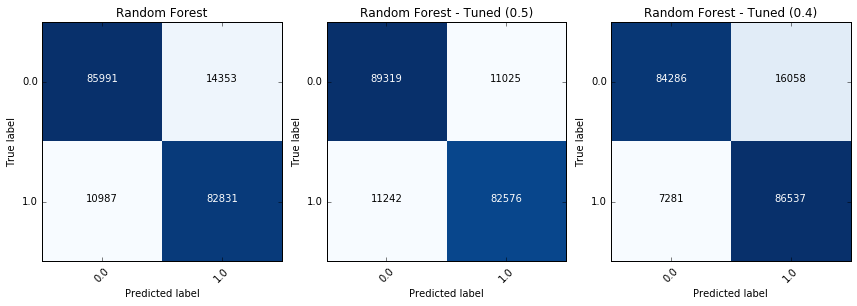

In [38]:
plt.figure(figsize=(12, 15))
sub1 = plt.subplot(1, 3, 1)
plot_confusion_matrix(confusion_matrices[0][1], class_names,
                          normalize=False,
                          title= confusion_matrices[0][0],
                          cmap=plt.cm.Blues)

sub2 = plt.subplot(1, 3, 2)
plot_confusion_matrix(confusion_matrices[1][1], class_names,
                          normalize=False,
                          title= confusion_matrices[1][0],
                          cmap=plt.cm.Blues)

sub3 = plt.subplot(1, 3, 3)
plot_confusion_matrix(confusion_matrices[2][1], class_names,
                          normalize=False,
                          title= confusion_matrices[2][0],
                          cmap=plt.cm.Blues)

In [39]:
X_test.shape

(194162, 19)

### New Predictions: Different Quarters for Test Set?

In [60]:
# Records expiring '2017 Q 2'
qtr = '2017 Q 2'
querystring = "SELECT * FROM CHURN_V1 WHERE EXPIRATION_DATE = '" + qtr + "'"

curs.execute(querystring)

start = time.time()
res = curs.fetchall()
end = time.time()
print(timer(start, end))

df_q2 = pd.DataFrame(res)
print("Number of records for " + qtr + ": ", df_q2.shape[0])

# Add column labels
df_q2.columns = ['INSTANCE_ID', 'CONTRACT_ID', 'OPTY_STATUS', 'ITEM_QUANTITY', 'PRICE_NEGOTIATED', 'ERP_ID', 'PARTY_SITE_NUMBER',
              'X_CDH_ID', 'PARTY_SITE_ID', 'PARTY_SITE_ID_VALIDATION', 'INSTALL_SITE_ID', 'SFDC_ID', 'SIC_CODE',
              'PRIMARYSIC', 'ACCOUNT_NAME', 'SALES_CHANNEL_CODE', 'INSTANCE_COUNT', 'START_DATE', 'EXPIRATION_DATE',
              'CONTRACT_LENGTH', 'INVENTORY_ITEM_ID', 'INVENTORY_ITEM_ID_VALIDATION', 'PRODUCT', 'BUYING_PROGRAM', 'SUB_REGION',
              'KEY_CUST_FLAG', 'INSTANCE_AGE', 'INDUSTRY', 'LOST_CONTRACTS', 'TOTAL_INSTANCES_OWNED','CONTRACT_LINE_END_DATE',
              'CONTRACT_LINE_STATUS_CODE', 'NXT_CONTRACT_LN_END_DATE', 'NXT_CONTRACT_LN_STATUS_CODE', 'PAST_CASE_COUNT',
              'HIGH_SEVERITY_COUNT', 'PAST_ESCALATION_COUNT', 'OPTY_AMT']

Process took: 0.0 hours, 0.0 minutes, 23.212729692459106 seconds
Number of records for 2017 Q 2:  143676


### Preprocessing

In [61]:
def preprocessing_churn(df):
    df_result = df.copy()
    
    def remove_year(row):
        return row[5:]

    # Too many missing values to fill
    df_result.drop(['KEY_CUST_FLAG', 'INDUSTRY'], axis=1, inplace=True)

    # Drop Indentifier Columns
    df_result.drop(['ERP_ID', 'PARTY_SITE_NUMBER', 'X_CDH_ID', 'PARTY_SITE_ID','PARTY_SITE_ID_VALIDATION', 
             'INSTALL_SITE_ID', 'SFDC_ID', 'PRIMARYSIC', 'INVENTORY_ITEM_ID', 'INVENTORY_ITEM_ID_VALIDATION'], 
            axis=1, inplace=True)

    # Drop Unnecessary Columns: These are dropped for now since the expiration date has passed.
    df_result.drop(['CONTRACT_LINE_END_DATE','CONTRACT_LINE_STATUS_CODE', 'NXT_CONTRACT_LN_END_DATE', 'NXT_CONTRACT_LN_STATUS_CODE'], 
            axis=1, inplace=True)
    
    # Fill numerical columns nan's with zeros
    df_result.PAST_CASE_COUNT.fillna(value=0, inplace=True)  # 80% missing values
    df_result.PAST_ESCALATION_COUNT.fillna(value=0, inplace=True)  # 80% missing values
    df_result.HIGH_SEVERITY_COUNT.fillna(value=0, inplace=True)  # 80% missing values
    df_result.OPTY_AMT.fillna(value=0, inplace=True)  # 41% missing values

    # Fill in with 'OTHER'
    df_result.SUB_REGION.fillna('OTHER', inplace=True)
    df_result.BUYING_PROGRAM.fillna('OTHER', inplace=True)

    # Fill in with 'NOT AVAILABLE'
    df_result.ACCOUNT_NAME.fillna('NOT AVAILABLE', inplace=True)
    df_result.SIC_CODE.fillna('NOT AVAILABLE', inplace=True)

    # Remove rows with * in ACCOUNT_NAME
    df_result = df_result[~df_result.ACCOUNT_NAME.str.startswith("*")]
    
    # Drop all rows with Missing Values
    print("Number of rows before dropping rows of missing values: ", df_result.shape[0])
    df_result.dropna(inplace=True)
    print("Number of rows AFTER dropping rows of missing values: ", df_result.shape[0])
    
    df_result['START_QTR'] = df_result.START_DATE.apply(remove_year)
    df_result['EXPIRATION_QTR'] = df_result.EXPIRATION_DATE.apply(remove_year)
    return df_result

In [62]:
df_q2_clean = preprocessing_churn(df_q2)

Number of rows before dropping rows of missing values:  143368
Number of rows AFTER dropping rows of missing values:  142199


### Encoding Categorical

In [63]:
df_q2_clean[categorical_cols_encoded]= df_q2_clean[categorical_cols].apply(lambda x: d_encoder[x.name].transform(x))

### Change OPTY_STATUS to 1.0/0.0 Values

In [64]:
# Transforming, Encoding 'Opty_status'
df_q2_clean['OPTY_STATUS_ENC'] = df_q2_clean.OPTY_STATUS.apply(change_label)

### Define X and y's

In [65]:
X_q2 = df_q2_clean[categorical_cols_encoded + numerical_cols]

y_q2 = df_q2_clean['OPTY_STATUS_ENC']

In [66]:
threshold = 0.4
start = time.time()
y_pred_q2 = [1.0 if val >= threshold else 0.0 for val in pl.predict_proba(X_q2)[:, 1]]
end = time.time()
print(timer(start, end))

Process took: 0.0 hours, 0.0 minutes, 28.34728693962097 seconds


In [67]:
show_scores(y_q2, y_pred_q2)

Prediction Accuracy for test set: 94.12%
Prediction Precision for test set: 91.89%
Prediction Recall for test set: 95.69%
Prediction F1-score for test set: 93.75%


Number of Instances, Contracts in 2017 Q 2: 142199 
Number of Instances, Contracts that Churned in 2017 Q 2: 65549 


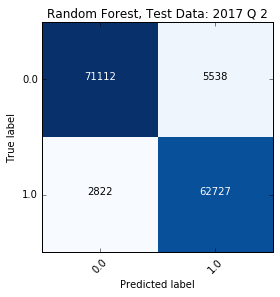

In [74]:
print("Number of Instances, Contracts in {0}: {1} ".format(qtr, len(y_q2)))
print("Number of Instances, Contracts that Churned in {0}: {1} ".format(qtr, int(y_q2.sum())))

plot_confusion_matrix( confusion_matrix(y_q2, y_pred_q2),  np.unique(y_q2),
                          normalize=False,
                          title= "Random Forest, Test Data: "+qtr,
                          cmap=plt.cm.Blues)

### Reference

$$Accuracy =\frac{tp + tn}{tp + tn + fp + fn}$$

$$ Precision = \frac{tp}{tp + fp} $$

$$ Recall = \frac{tp}{tp + fn} $$

$$ f1 Score = 2 \, \frac{precision*recall}{precision + recall} $$

### Prediction for 2017 Q 4

In [75]:
# Records expiring '2017 Q 4'
qtr = '2017 Q 4'
querystring = "SELECT * FROM CHURN_V1 WHERE EXPIRATION_DATE = '" + qtr + "'"

curs.execute(querystring)

start = time.time()
res = curs.fetchall()
end = time.time()
print(timer(start, end))

df_q4 = pd.DataFrame(res)
print("Number of records for " + qtr + ": ", df_q4.shape[0])

# Add column labels
df_q4.columns = ['INSTANCE_ID', 'CONTRACT_ID', 'OPTY_STATUS', 'ITEM_QUANTITY', 'PRICE_NEGOTIATED', 'ERP_ID', 'PARTY_SITE_NUMBER',
              'X_CDH_ID', 'PARTY_SITE_ID', 'PARTY_SITE_ID_VALIDATION', 'INSTALL_SITE_ID', 'SFDC_ID', 'SIC_CODE',
              'PRIMARYSIC', 'ACCOUNT_NAME', 'SALES_CHANNEL_CODE', 'INSTANCE_COUNT', 'START_DATE', 'EXPIRATION_DATE',
              'CONTRACT_LENGTH', 'INVENTORY_ITEM_ID', 'INVENTORY_ITEM_ID_VALIDATION', 'PRODUCT', 'BUYING_PROGRAM', 'SUB_REGION',
              'KEY_CUST_FLAG', 'INSTANCE_AGE', 'INDUSTRY', 'LOST_CONTRACTS', 'TOTAL_INSTANCES_OWNED','CONTRACT_LINE_END_DATE',
              'CONTRACT_LINE_STATUS_CODE', 'NXT_CONTRACT_LN_END_DATE', 'NXT_CONTRACT_LN_STATUS_CODE', 'PAST_CASE_COUNT',
              'HIGH_SEVERITY_COUNT', 'PAST_ESCALATION_COUNT', 'OPTY_AMT']

Process took: 0.0 hours, 0.0 minutes, 17.705551385879517 seconds
Number of records for 2017 Q 4:  116441


In [76]:
# Preprocess
df_q4_clean = preprocessing_churn(df_q4)

Number of rows before dropping rows of missing values:  116298
Number of rows AFTER dropping rows of missing values:  107804


In [77]:
# Encode Variables
df_q4_clean[categorical_cols_encoded]= df_q4_clean[categorical_cols].apply(lambda x: d_encoder[x.name].transform(x))

In [78]:
# Transforming, Encoding 'Opty_status'
df_q4_clean['OPTY_STATUS_ENC'] = df_q4_clean.OPTY_STATUS.apply(change_label)

In [79]:
# Define X and y's
X_q4 = df_q4_clean[categorical_cols_encoded + numerical_cols]

y_q4 = df_q4_clean['OPTY_STATUS_ENC']

In [80]:
threshold = 0.4
start = time.time()
y_pred_proba_q4 = pl.predict_proba(X_q4)[:, 1]
y_pred_q4 = [1.0 if val >= threshold else 0.0 for val in y_pred_proba_q4]
end = time.time()
print(timer(start, end))

Process took: 0.0 hours, 0.0 minutes, 22.561657428741455 seconds


### User-Friendly Output

In [92]:
# Add Churn Probability: 'CHURN_PROBABILITY'
df_q4_clean['CHURN_PROBABILITY'] = y_pred_proba_q4
df_q4_clean['PREDICTION'] = ['CHURN' if val >= 0.4 else 'NOT CHURN' for val in y_pred_proba_q4]

In [116]:
df_results = df_q4_clean.sort_values(['CHURN_PROBABILITY'], ascending=False)[['INSTANCE_ID','CONTRACT_ID',
                                                                              'START_DATE', 'EXPIRATION_DATE', 
                                                                              'PREDICTION', 'OPTY_STATUS', 'CHURN_PROBABILITY']]

In [117]:
df_results.head(500)

,INSTANCE_ID,CONTRACT_ID,START_DATE,EXPIRATION_DATE,PREDICTION,OPTY_STATUS,CHURN_PROBABILITY
44358,3296563,2085217,2016 Q 4,2017 Q 4,CHURN,LOST,1.000000
86227,3291922,2113836,2016 Q 4,2017 Q 4,CHURN,NEW,1.000000
112720,590528,436811,2014 Q 4,2017 Q 4,CHURN,LOST,1.000000
98740,3296571,2085217,2016 Q 4,2017 Q 4,CHURN,LOST,1.000000
37993,1274914,1656228,2014 Q 4,2017 Q 4,CHURN,LOST,1.000000
44805,1203046,561539,2014 Q 4,2017 Q 4,CHURN,LOST,1.000000
38228,3411523,2214901,2016 Q 4,2017 Q 4,CHURN,NEW,1.000000
49635,593557,202524,2014 Q 4,2017 Q 4,CHURN,LOST,1.000000
108311,666649,200546,2014 Q 4,2017 Q 4,CHURN,LOST,1.000000
104847,3291917,2113836,2016 Q 4,2017 Q 4,CHURN,NEW,1.000000


In [102]:
# Save to .csv
df_results.reset_index(inplace=True)
df_results.to_csv('churn_probability.csv', sep=',', index=False)

### Summary of Predictions

In [128]:
df_results.groupby('PREDICTION')['INSTANCE_ID'].count()

PREDICTION
CHURN        41900
NOT CHURN    65904
Name: INSTANCE_ID, dtype: int64

In [138]:
print("Number of instances (total): ", df_results.shape[0])
print("Percentage of Instances that Churned/LOST: {:.2f}%".format((df_results.groupby('PREDICTION')['INSTANCE_ID'].count()[0]/df_results.shape[0])*100))
print("Percentage of Instances Not Churned/RENEWED: {:.2f}%".format((df_results.groupby('PREDICTION')['INSTANCE_ID'].count()[1]/df_results.shape[0])*100))

Number of instances (total):  107804
Percentage of Instances that Churned/LOST: 38.87%
Percentage of Instances Not Churned/RENEWED: 61.13%


### Feature Importance

Process took: 0.0 hours, 8.0 minutes, 3.2263998985290527 seconds
Feature ranking:
1. INSTANCE_AGE (0.152507)
2. PRICE_NEGOTIATED (0.128512)
3. OPTY_AMT (0.126103)
4. INSTANCE_COUNT (0.080122)
5. SIC_CODE_ENC (0.073492)
6. CONTRACT_LENGTH (0.062341)
7. ITEM_QUANTITY (0.053485)
8. LOST_CONTRACTS (0.051290)
9. TOTAL_INSTANCES_OWNED (0.050270)
10. ACCOUNT_NAME_ENC (0.049656)
11. PRODUCT_ENC (0.042905)
12. SUB_REGION_ENC (0.028031)
13. EXPIRATION_QTR_ENC (0.023136)
14. START_QTR_ENC (0.020842)
15. PAST_CASE_COUNT (0.019308)
16. BUYING_PROGRAM_ENC (0.016597)
17. SALES_CHANNEL_CODE_ENC (0.012082)
18. HIGH_SEVERITY_COUNT (0.006878)
19. PAST_ESCALATION_COUNT (0.002444)


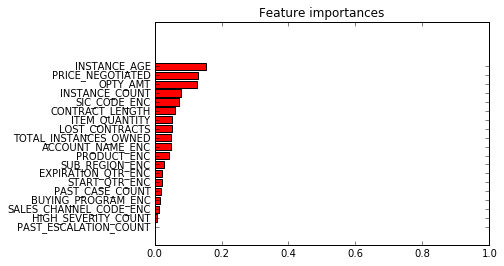

In [115]:
start = time.time()
importances = RF(max_depth=None, n_estimators=500, max_features='log2').fit(X_train, y_train).feature_importances_
end = time.time()
print(timer(start, end))
indices = np.argsort(importances)[::-1]

feat_name = {}
col_name = categorical_cols_encoded + numerical_cols

for ind in indices:
    feat_name[ind] = col_name[ind]

# Print the feature ranking
print("Feature ranking:")

xaxis_names = []
for f in range(X_train.shape[1]):
    xaxis_names.append(feat_name[indices[f]])
    print("%d. %s (%f)" % (f + 1, feat_name[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), xaxis_names)
plt.xlim([0, 1])
plt.gca().invert_yaxis()
plt.show()

### Visualizing Random Forest

In [162]:
from sklearn import tree

In [164]:
start = time.time()
clf_rf = RF(max_depth=None, n_estimators=500, max_features='log2').fit(X_train, y_train)
end = time.time()
print("Training time: ", timer(start, end))

start = time.time()
for i, tree_in_forest in enumerate(clf_rf.estimators_):
    if i % 100 == 0:
        with open('tree_' + str(i) + '.dot', 'w') as my_file:
            my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
end = time.time()
timer(start, end)

Training time:  Process took: 0.0 hours, 8.0 minutes, 16.712855577468872 seconds


'Process took: 0.0 hours, 1.0 minutes, 38.02237319946289 seconds'

In [168]:
clf_rf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=337039339, splitter='best')

In [166]:
import os

In [167]:
os.system('dot -Tpng tree_0.dot -o tree_0.png')

1

### Feature Importance: Part 2

In [ ]:
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print "Features sorted by their score:"
print sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True)


# Get scores for all training on X_train, y_train, X_test, y_test

# Remove one column and train and test again

# Compare first score to score of removed column

### Connecting to MongoDB

In [141]:
from pymongo import MongoClient

In [150]:
client = MongoClient('mongodb://mongo-elb-classic-193773297.us-west-2.elb.amazonaws.com:443/')

In [151]:
client.database_names

<bound method MongoClient.database_names of MongoClient(host=['mongo-elb-classic-193773297.us-west-2.elb.amazonaws.com:443'], document_class=dict, tz_aware=False, connect=True)>